## 데이터 탐색의 목적
1. 데이터가 어떤 식으로 구성된지 확인하고 분석의 방향을 결정 
2. 사용자와 아이템의 특성을 파악하고 좋은 피쳐와 아이디어를 발굴 

In [1]:
import pickle
import pandas as pd
import numpy as np
import os, sys, gc 
from plotnine import *
import plotnine

from tqdm import tqdm_notebook
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
from matplotlib import rc
import re
from matplotlib.ticker import PercentFormatter
import datetime
from math import log # IDF 계산을 위해

In [2]:
%config InlineBackend.figure_format = 'retina'

mpl.font_manager._rebuild()
mpl.pyplot.rc('font', family='NanumBarunGothic')
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['font.family'] = 'NanumBarunGothic'

fontpath = 'C:/Users/User/Anaconda3/Lib/site-packages/matplotlib/mpl-data/fonts/ttf/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9).get_name()

In [3]:
warnings.filterwarnings(action='ignore')

## 데이터 로드

In [4]:
path = 'C:/Users/User/Documents/T아카데미/T 아카데미/input/'
print(os.listdir(path))

['data.0', 'magazine.json', 'metadata.json', 'predict', 'read', 'users.json']


### 데이터 스키마
![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FdkFzLS%2Fbtqyt68KeI6%2FAiLvkFGi9wHMnXu57VkcOk%2Fimg.png)

1. User 
2. contents 
3. magazine 
4. metadata
5. read

데이터의 종류는 크게 5가지로 분류가 가능합니다. 하지만, 메타 데이터의 magazine_id와 Magazine데이터의 id와 매핑되는 등 컬럼명이 조금 다른 점을 볼 수 있습니다. 해당 사항에 유의하면서 각 파일별로 어떠한 특성을 가지고 있는 지 살펴보겠습니다. 

In [5]:
# pd.read_json : json 형태의 파일을 dataframe 형태로 불러오는 코드 
magazine = pd.read_json(path + 'magazine.json', lines=True) # lines = True : Read the file as a json object per line.
metadata = pd.read_json(path + 'metadata.json', lines=True)
users = pd.read_json(path + 'users.json', lines=True)

json 파일의 경우는 pd.read_json을 이용해서 쉽게 불러왔습니다. 하지만, read의 데이터는 파일명이 "시작일_종료일" 형태로 제공되었고 파일의 갯수도 3600개로 많습니다. 그렇기에 경로내에 있는 파일을 한번에 불러와서 하나의 파일로 합치는 작업이 필요합니다. 

In [8]:
import itertools
from itertools import chain
import glob
import os 

input_read_path = path + 'read/read/'
# os.listdir : 해당 경로에 있는 모든 파일들을 불러오는 명령어 
file_list = os.listdir(input_read_path)
print(file_list[0:2])

['2018100100_2018100101', '2018100101_2018100102']


In [9]:
%%time 
read_df_list = []
exclude_file_lst = ['read.tar', '.2019010120_2019010121.un~']
for file in tqdm_notebook(file_list):
    # 예외처리 
    if file in exclude_file_lst:
        continue 
    else:
        file_path = input_read_path + file
        df_temp = pd.read_csv(file_path, header=None, names=['raw'])
        # file명을 통해서 읽은 시간을 추출(from, to)
        df_temp['from'] = file.split('_')[0]
        df_temp['to'] = file.split('_')[1]
        read_df_list.append(df_temp)
    
read_df = pd.concat(read_df_list)


Wall time: 12.2 s


In [10]:
read_df.head()

,raw,from,to
0,#e208be4ffea19b1ceb5cea2e3c4dc32c @kty0613_91,2018100100,2018100101
1,#0a3d493f3b2318be80f391eaa00bfd1c @miamiyoung_...,2018100100,2018100101
2,#b90d3ee7ed0d7d827aae168e159749f1 @joeunha_4 @...,2018100100,2018100101
3,#b8b9d09fe2961fd62edc94912bf75a90 @hyejinchoi_...,2018100100,2018100101
4,#072f742eda9359cdac03ad080193c11d @doyeonsunim...,2018100100,2018100101


In [11]:
read_df['user_id'] = read_df['raw'].apply(lambda x: x.split(' ')[0])
read_df['article_id'] = read_df['raw'].apply(lambda x: x.split(' ')[1:])
read_df.head()

,raw,from,to,user_id,article_id
0,#e208be4ffea19b1ceb5cea2e3c4dc32c @kty0613_91,2018100100,2018100101,#e208be4ffea19b1ceb5cea2e3c4dc32c,"[@kty0613_91, ]"
1,#0a3d493f3b2318be80f391eaa00bfd1c @miamiyoung_...,2018100100,2018100101,#0a3d493f3b2318be80f391eaa00bfd1c,"[@miamiyoung_31, @banksalad_49, @rlfrjsdn_95, ..."
2,#b90d3ee7ed0d7d827aae168e159749f1 @joeunha_4 @...,2018100100,2018100101,#b90d3ee7ed0d7d827aae168e159749f1,"[@joeunha_4, @yoonvi_3, ]"
3,#b8b9d09fe2961fd62edc94912bf75a90 @hyejinchoi_...,2018100100,2018100101,#b8b9d09fe2961fd62edc94912bf75a90,"[@hyejinchoi_122, @hyejinchoi_86, @hyejinchoi_..."
4,#072f742eda9359cdac03ad080193c11d @doyeonsunim...,2018100100,2018100101,#072f742eda9359cdac03ad080193c11d,"[@doyeonsunim_240, @k52524_297, @bule13_33, @k..."


위와 같이 전처리한 경우에 하나의 user_id에 여러개의 article_id가 매핑됩니다. 분석의 편의상 하나의 user_id에 한개의 article_id가 매핑(1:1)되도록 article_id의 list를 풀어주는 작업을 진행합니다. 

In [75]:
# 하나의 리스트로 반환하는 코드 
def chainer(s):
    return list(itertools.chain.from_iterable(s))

# article_id의 리스트가 풀어지면서 길어지는 것을 맞추기 위해서 np.repeat을 통해 같은 정보를 반복
read_cnt_by_user = read_df['article_id'].map(len)
read_rowwise = pd.DataFrame({'from': np.repeat(read_df['from'], read_cnt_by_user),
                             'to': np.repeat(read_df['to'], read_cnt_by_user),
                             'user_id': np.repeat(read_df['user_id'], read_cnt_by_user),
                             'article_id': chainer(read_df['article_id'])})

read_rowwise.reset_index(drop=True, inplace=True)

In [11]:
read_rowwise.head()

,from,to,user_id,article_id
0,2018100100,2018100101,#e208be4ffea19b1ceb5cea2e3c4dc32c,@kty0613_91
1,2018100100,2018100101,#e208be4ffea19b1ceb5cea2e3c4dc32c,
2,2018100100,2018100101,#0a3d493f3b2318be80f391eaa00bfd1c,@miamiyoung_31
3,2018100100,2018100101,#0a3d493f3b2318be80f391eaa00bfd1c,@banksalad_49
4,2018100100,2018100101,#0a3d493f3b2318be80f391eaa00bfd1c,@rlfrjsdn_95


## 데이터 탐색 - Users

In [12]:
users.head()

,keyword_list,following_list,id
0,[],"[@perytail, @brunch]",#901985d8bc4c481805c4a4f911814c4a
1,[],"[@holidaymemories, @wadiz, @sciforus, @dailydu...",#1fd89e9dcfa64b45020d9eaca54e0eed
2,[],"[@commerceguy, @sunsutu, @kakao-it, @joohoonja...",#1d94baaea71a831e1f33e1c6bd126ed5
3,[],"[@amberjeon48, @forsy20, @nemotokki, @hawann, ...",#04641c01892b12dc018b1410e4928c0d
4,[],"[@dwcha7342, @iammento, @kakao-it, @dkam, @ant...",#65bcaff862aadff877e461f54187ab62


변수설명
- id : 사용자의 고유 식별코드 
- following_list : 내가 구독하고 있는 작가의 아이디 목록
- keyword_list : 독자가 아닌 작가일 경우에 작가의 글로 유입된 검색 키워드

In [15]:
print("사용자의 수: ", users.shape[0])
print("작가의 수: ", users[users['keyword_list'].apply(lambda x: len(x)) != 0].shape[0])

사용자의 수:  310758
작가의 수:  11544


사용자의 수는 30만명이고 그 중에서도 작가는 1만명으로 약 3.3%정도를 차지하고 있습니다. 

In [18]:
print("구독하는 작가가 있는 사용자의 수: ", users[users['following_list'].apply(lambda x: len(x)) != 0].shape[0])
print("{}가 구독하는 작가가 있을 정도로 많은 비율을 차지".format('97.6%'))

구독하는 작가가 있는 사용자의 수:  303490
97.6%가 구독하는 작가가 있을 정도로 많은 비율을 차지


In [15]:
users[users['keyword_list'].apply(lambda x: len(x)) != 0].head(1)['keyword_list'].values[0][0:10]

[{'cnt': 1, 'keyword': '200일 이벤트'},
 {'cnt': 2, 'keyword': '4dx 음료'},
 {'cnt': 1, 'keyword': '4dx 주의사항'},
 {'cnt': 1, 'keyword': '8대2가르마펌'},
 {'cnt': 1, 'keyword': 'Gott ist tot'},
 {'cnt': 1, 'keyword': 'kt OPT 빨간불'},
 {'cnt': 1, 'keyword': 'kt opt 불'},
 {'cnt': 1, 'keyword': 'kt 공유기 opt'},
 {'cnt': 3, 'keyword': 'kt 모뎀'},
 {'cnt': 5, 'keyword': 'kt 모뎀 opt'}]

사용자별로 구독하는 작가에 대해서 어떤 특징을 가지고 있는 지 분석을 시작해보겠습니다. 기본적인 아이디어로는 아래와 같습니다. 
1. 사용자별로 구독하는 작가의 수는 얼마나 되는지? 
2. 어떤 작가를 주로 구독하는지? 
3. 주로 유입되는 키워드는 무엇인지? 

In [20]:
users['following_count'] = users['following_list'].apply(lambda x: len(x))

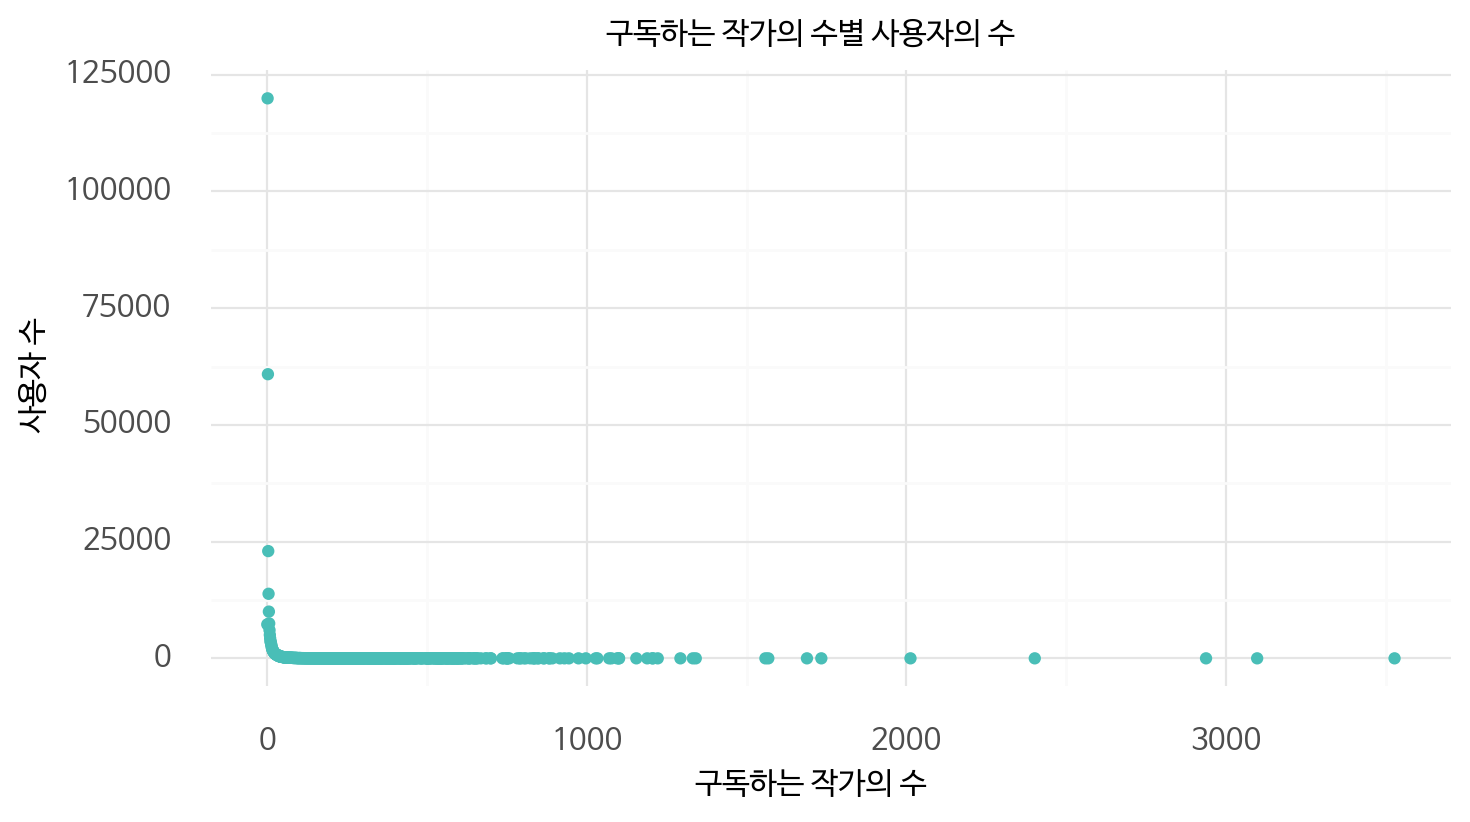

<ggplot: (-9223371843347210545)>

In [94]:
following_cnt_by_id = pd.DataFrame(users.groupby('following_count')['id'].count()).reset_index()

(ggplot(data=following_cnt_by_id)
    + geom_point(aes(x='following_count', y='id'), colour = '#49beb7')
    + theme_minimal()
    + ggtitle("구독하는 작가의 수별 사용자의 수")
    + labs(x="구독하는 작가의 수", y="사용자 수") 
    + theme(text = element_text(fontproperties=font),
         axis_text_x = element_text(angle=60, color='black'),
         axis_text_y = element_text(color='black'),
         figure_size=(8,4))
 )

In [22]:
pd.DataFrame(users['following_count'].describe()).T

,count,mean,std,min,25%,50%,75%,max
following_count,310758.0,8.420955,30.286427,0.0,1.0,2.0,5.0,3528.0


구독작가의 수의 중위수는 2명으로 분포가 극단적으로 왼쪽으로 치우친 형태인 것을 볼 수 있습니다. 이번에는 반대로 사람들이 어떤 작가를 구독하는 지 살펴보겠습니다. 

In [23]:
following_cnt_by_user = users['following_list'].map(len)
following_rowwise = pd.DataFrame({'user_id': np.repeat(users['id'], following_cnt_by_user),
                             'author_id': chainer(users['following_list'])})

following_rowwise.reset_index(drop=True, inplace=True)

In [24]:
following_rowwise.head()

,user_id,author_id
0,#901985d8bc4c481805c4a4f911814c4a,@perytail
1,#901985d8bc4c481805c4a4f911814c4a,@brunch
2,#1fd89e9dcfa64b45020d9eaca54e0eed,@holidaymemories
3,#1fd89e9dcfa64b45020d9eaca54e0eed,@wadiz
4,#1fd89e9dcfa64b45020d9eaca54e0eed,@sciforus


In [31]:
following_cnt_by_id = following_rowwise.groupby('author_id')['user_id'].agg({'count'}).reset_index().sort_values(by='count', ascending=False)
following_cnt_by_id.head(10).T

,1828,3902,14758,12641,16668,15411,16431,6606,9510,3995
author_id,@brunch,@dryjshin,@tenbody,@roysday,@yumileewyky,@varo,@yoonash,@imagineer,@lunarshore,@ebprux
count,292413,9011,8615,8500,6116,5688,5653,5483,5414,5374


상위 10명의 작가를 보면 1등인 brunch는 공식사이트로 가장 많은 구독자의 수를 보유하고 있고 2등부터는 차이가 크게 변하는 것을 볼 수 있습니다. 

In [192]:
following_cnt_by_id_ = following_cnt_by_id[following_cnt_by_id['author_id'] != '@brunch']
(ggplot(data=following_cnt_by_id_)
    + geom_histogram(aes(x='count', y='stat(count)'), fill = '#49beb7', binwidth=10)
    + theme_minimal()
    + ggtitle("작가별로 평균 구독자의 수")
    + labs(x="평균 구독자의 수", y="빈도") 
    + theme(text = element_text(fontproperties=font),
         axis_text_x = element_text(angle=60, color='black'),
         axis_text_y = element_text(color='black'),
         axis_line=element_line(color="black"),
         axis_ticks=element_line(color = "grey"),
         figure_size=(8,4))
 )

KeyError: 'author_id'

In [37]:
pd.DataFrame(following_cnt_by_id['count'].describe()).T

,count,mean,std,min,25%,50%,75%,max
count,16905.0,154.799113,2284.28783,1.0,5.0,17.0,80.0,292413.0


실제로 히스토그램을 살펴보면 대부분의 값이 왼쪽에 치우친 롱테일형태의 데이터임을 알 수 있습니다. 

In [50]:
keyword_dict = {}
for i in tqdm_notebook(users[users['keyword_list'].apply(lambda x: len(x)) != 0]['keyword_list'].values):
    for j in range(0, len(i)):
        word = i[j]['keyword']
        cnt = i[j]['cnt']
        try:
            keyword_dict[word] += cnt
        except:
            keyword_dict[word] = cnt

In [69]:
# wordcloud에 대한 자세한 정보는 lovit님의 블로그 https://lovit.github.io/nlp/2018/04/17/word_cloud/를 참고하시기 바랍니다. 
from wordcloud import WordCloud
from PIL import Image

wordcloud = WordCloud(
    font_path = fontpath,
    width = 800,
    height = 800,
    background_color="white",
    mask= np.array(Image.open("./figure/RS-KR.png"))

)
wordcloud = wordcloud.generate_from_frequencies(keyword_dict)

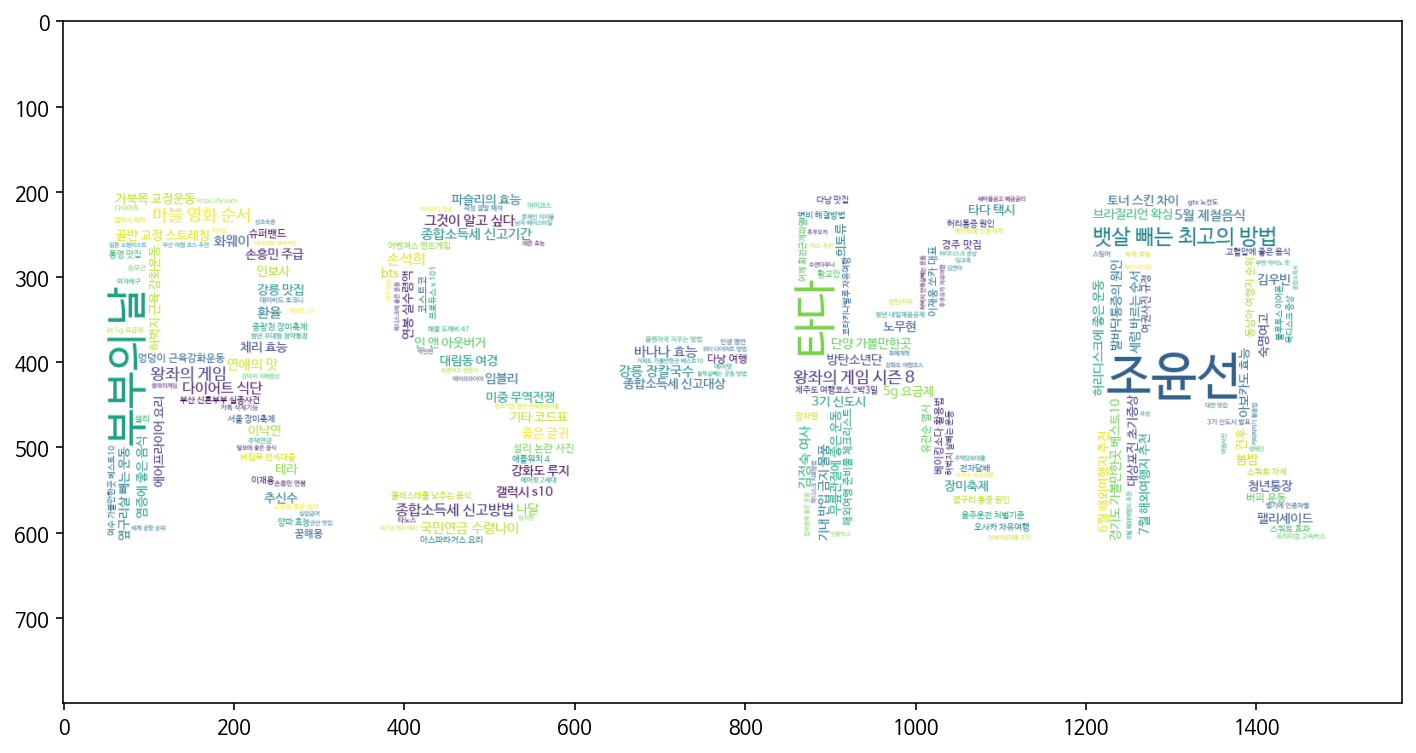

In [70]:
fig = plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.show()
fig.savefig('wordcloud.png')

## 데이터 탐색 - Read

In [76]:
read_rowwise.head()

,from,to,user_id,article_id
0,2018100100,2018100101,#e208be4ffea19b1ceb5cea2e3c4dc32c,@kty0613_91
1,2018100100,2018100101,#e208be4ffea19b1ceb5cea2e3c4dc32c,
2,2018100100,2018100101,#0a3d493f3b2318be80f391eaa00bfd1c,@miamiyoung_31
3,2018100100,2018100101,#0a3d493f3b2318be80f391eaa00bfd1c,@banksalad_49
4,2018100100,2018100101,#0a3d493f3b2318be80f391eaa00bfd1c,@rlfrjsdn_95


변수설명
- from : 시작일 
- to : 종료일
- user_id : 사용자의 식별코드
- article_id : 작품의 식별코드

데이터를 보면 article_id에 결측치가 있는 경우가 있습니다. 해당 결측치는 본문의 글이 삭제되거나 작가가 탈퇴하는 등의 이슈로 발생한 문제입니다. 이러한 article_id는 추천에 영향을 주지 않도록 전처리를 통해 제거해줍니다. 

In [77]:
# article_id가 없는 경우 삭제 
read_rowwise = read_rowwise[read_rowwise['article_id'] != ''].reset_index(drop=True)

In [78]:
# 읽은날짜와 시간 추출 
read_rowwise['dt'] = read_rowwise['from'].astype(str).apply(lambda x: x[0:8]).astype(int)
read_rowwise['hr'] = read_rowwise['from'].astype(str).apply(lambda x: x[8:10]).astype(int)
read_rowwise['reg_dt'] = pd.to_datetime(read_rowwise['dt'].astype(str).apply(lambda x: x[0:4] + '-' + x[4:6] + '-' + x[6:8]))

In [82]:
read_rowwise['article_id'].value_counts()[0:5]

@brunch_141        97206
@brunch_151        66903
@brunch_145        31162
@tenbody_1305      28922
@intlovesong_28    23760
Name: article_id, dtype: int64

In [81]:
following_cnt_by_id.head(10).T

,1828,3902,14758,12641,16668,15411,16431,6606,9510,3995
author_id,@brunch,@dryjshin,@tenbody,@roysday,@yumileewyky,@varo,@yoonash,@imagineer,@lunarshore,@ebprux
count,292413,9011,8615,8500,6116,5688,5653,5483,5414,5374


사람들이 자주 읽는 글의 목록을 살펴보면 brunch의 글이 3개나 있는 것을 볼 수 있습니다. 또한, 구독자가 많은 상위 10명의 작가에 해당하는 글이 4건이나 있는 것을 볼 수 있습니다. 실제로 구독자가 많은 순위와 얼마나 비슷한지 살펴보기 위해서 사람들이 많이 글을 읽는 상위 10명의 작가를 보겠습니다. 

In [83]:
read_rowwise['author_id'] = read_rowwise['article_id'].apply(lambda x: str(x).split('_')[0])
pd.DataFrame(read_rowwise['author_id'].value_counts()).head(10).T

,@brunch,@tenbody,@jordan777,@dailylife,@seochogirl,@binkond,@nareun,@wikitree,@merryseo,@peregrino97
author_id,417926,332252,315323,259487,193401,158946,156547,120861,114438,103174


구독자가 많은 상위 10건과 읽는 사용자가 많은 상위 10건을 보면 의외로 brunch와 tenbody 두개만 겹치는 것을 볼 수 있습니다. 이에 대해서 좀 더 자세히 살펴보기 위해서 사용자들이 구독하는 작가의 글을 얼마나 읽는 지 살펴보겠습니다. 

In [85]:
# 구독하는 작가의 글을 읽는 비율 vs 그렇지 않은 작가의 글을 읽는 비율 
following_rowwise['is_following'] = 1
read_rowwise = pd.merge(read_rowwise, following_rowwise, how='left', on=['user_id', 'author_id'])

In [86]:
read_rowwise['is_following'] = read_rowwise['is_following'].fillna(0)
read_rowwise['is_following'].value_counts(normalize=True)

0.0    0.646381
1.0    0.353619
Name: is_following, dtype: float64

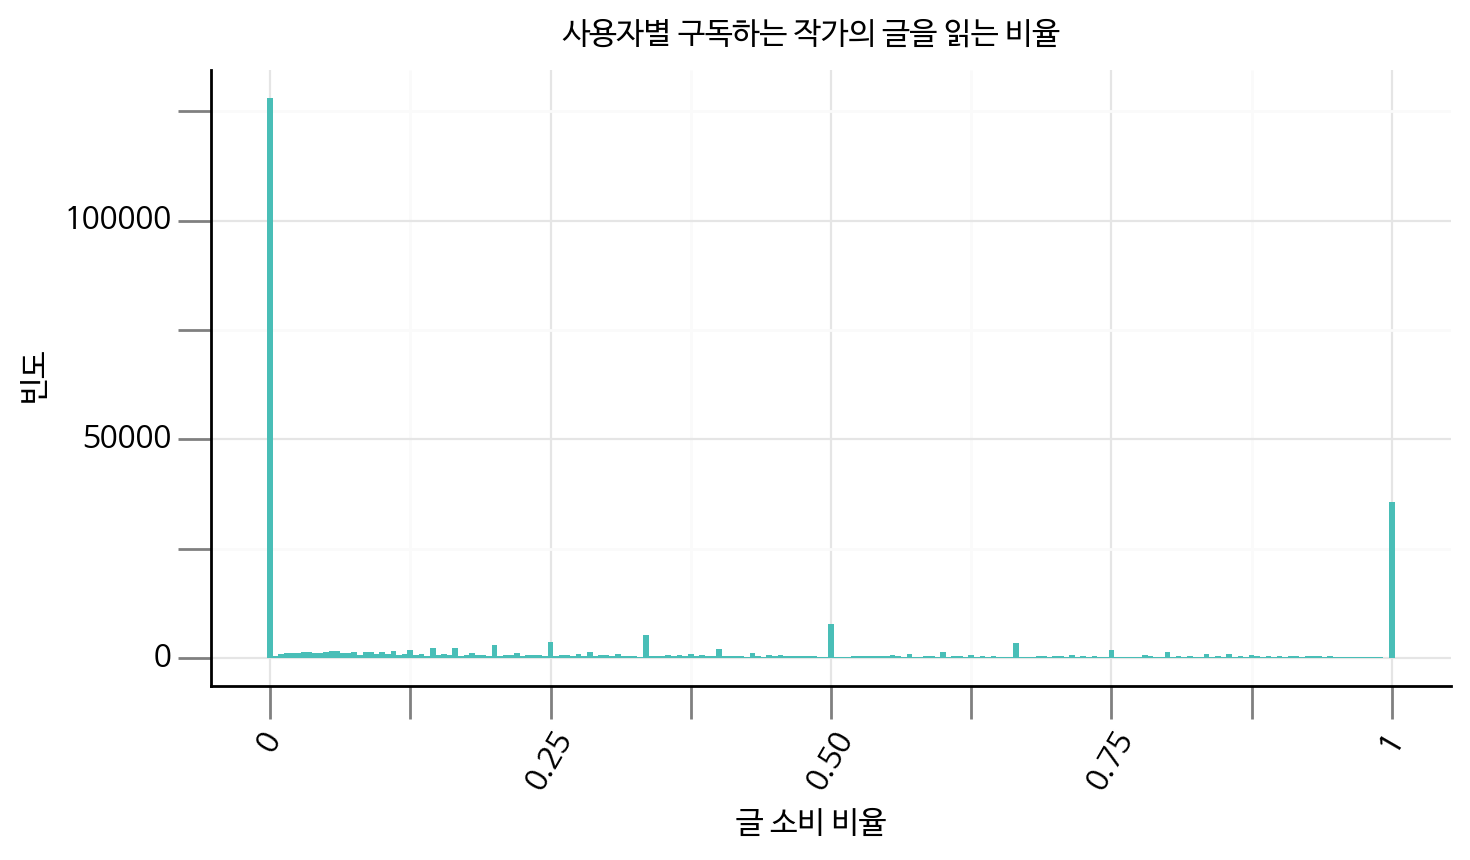

<ggplot: (-9223371843199053652)>

In [191]:
read_following_author = read_rowwise.groupby(['user_id'])['is_following'].agg({'mean'}).reset_index()

(ggplot(data=read_following_author)
    + geom_histogram(aes(x='mean', y='stat(count)'), fill = '#49beb7', binwidth=0.005)
    + theme_minimal()
    + ggtitle("사용자별 구독하는 작가의 글을 읽는 비율")
    + labs(x="글 소비 비율", y="빈도") 
    + theme(text = element_text(fontproperties=font),
         axis_text_x = element_text(angle=60, color='black'),
         axis_text_y = element_text(color='black'),
         axis_line=element_line(color="black"),
         axis_ticks=element_line(color = "grey"),
         figure_size=(8,4))
 )

글의 소비 비율에 따른 빈도수를 살펴보면 0과 1에 극단적으로 치우친 형태임을 알 수 있습니다. **추천시에 글 소비 비율이 1에 가까운 사용자에게는 구독하는 작가의 글을 위주로 추천을 해주고 글 소비 비율이 0에 가까운 사용자에게는 전체 작가의 글을 다양하게 추천해주는 게 좋을 것이라는 인사이트를 얻을 수 있습니다.**

글 소비 비율이 0에 가까운 사용자의 경우 왜 그러한 행동을 보이는 지 살펴보도록 하겠습니다. 

첫번째로 발견한 이유는 애초에 글을 조금만 읽었을 가능성이 있습니다. 실제로 글 소비 비율이 1인 사용자 또한 동일한 문제를 가지고 있을 수도 있습니다. 

In [103]:
read_rowwise[read_rowwise['user_id'] == '#0000d1188f75d0b0ea7a8e23a2b760e5']

,from,to,user_id,article_id,dt,hr,author_id,is_following
592504,2018100421,2018100422,#0000d1188f75d0b0ea7a8e23a2b760e5,@hyunilikes_156,20181004,21,@hyunilikes,0.0


In [104]:
read_rowwise[read_rowwise['user_id'] == '#0000eea6d339abfd02ed590bc451fc63']

,from,to,user_id,article_id,dt,hr,author_id,is_following
17295822,2019020114,2019020115,#0000eea6d339abfd02ed590bc451fc63,@sucopy_182,20190201,14,@sucopy,0.0


두번째로 발견한 이유는 시간이 흐름에 따라서 사용자의 선호가 바뀔 수 있습니다. 아래의 사용자를 보면 초기에 구독했던 작가들은 많으나 시간이 지나면서 읽지 않고 가장 최근 한달에는 구독하지 않은 작가들의 글을 더 많이 읽는 모습을 볼 수 있습니다. 

In [170]:
# 0.1 246
user_id = '#a87e970972364bb14a542f57b0933db9'
read_user = read_rowwise[read_rowwise['user_id'] == user_id]
read_user = read_user.groupby(['reg_dt', 'is_following', 'author_id'])['author_id'].agg({'count'}).reset_index()

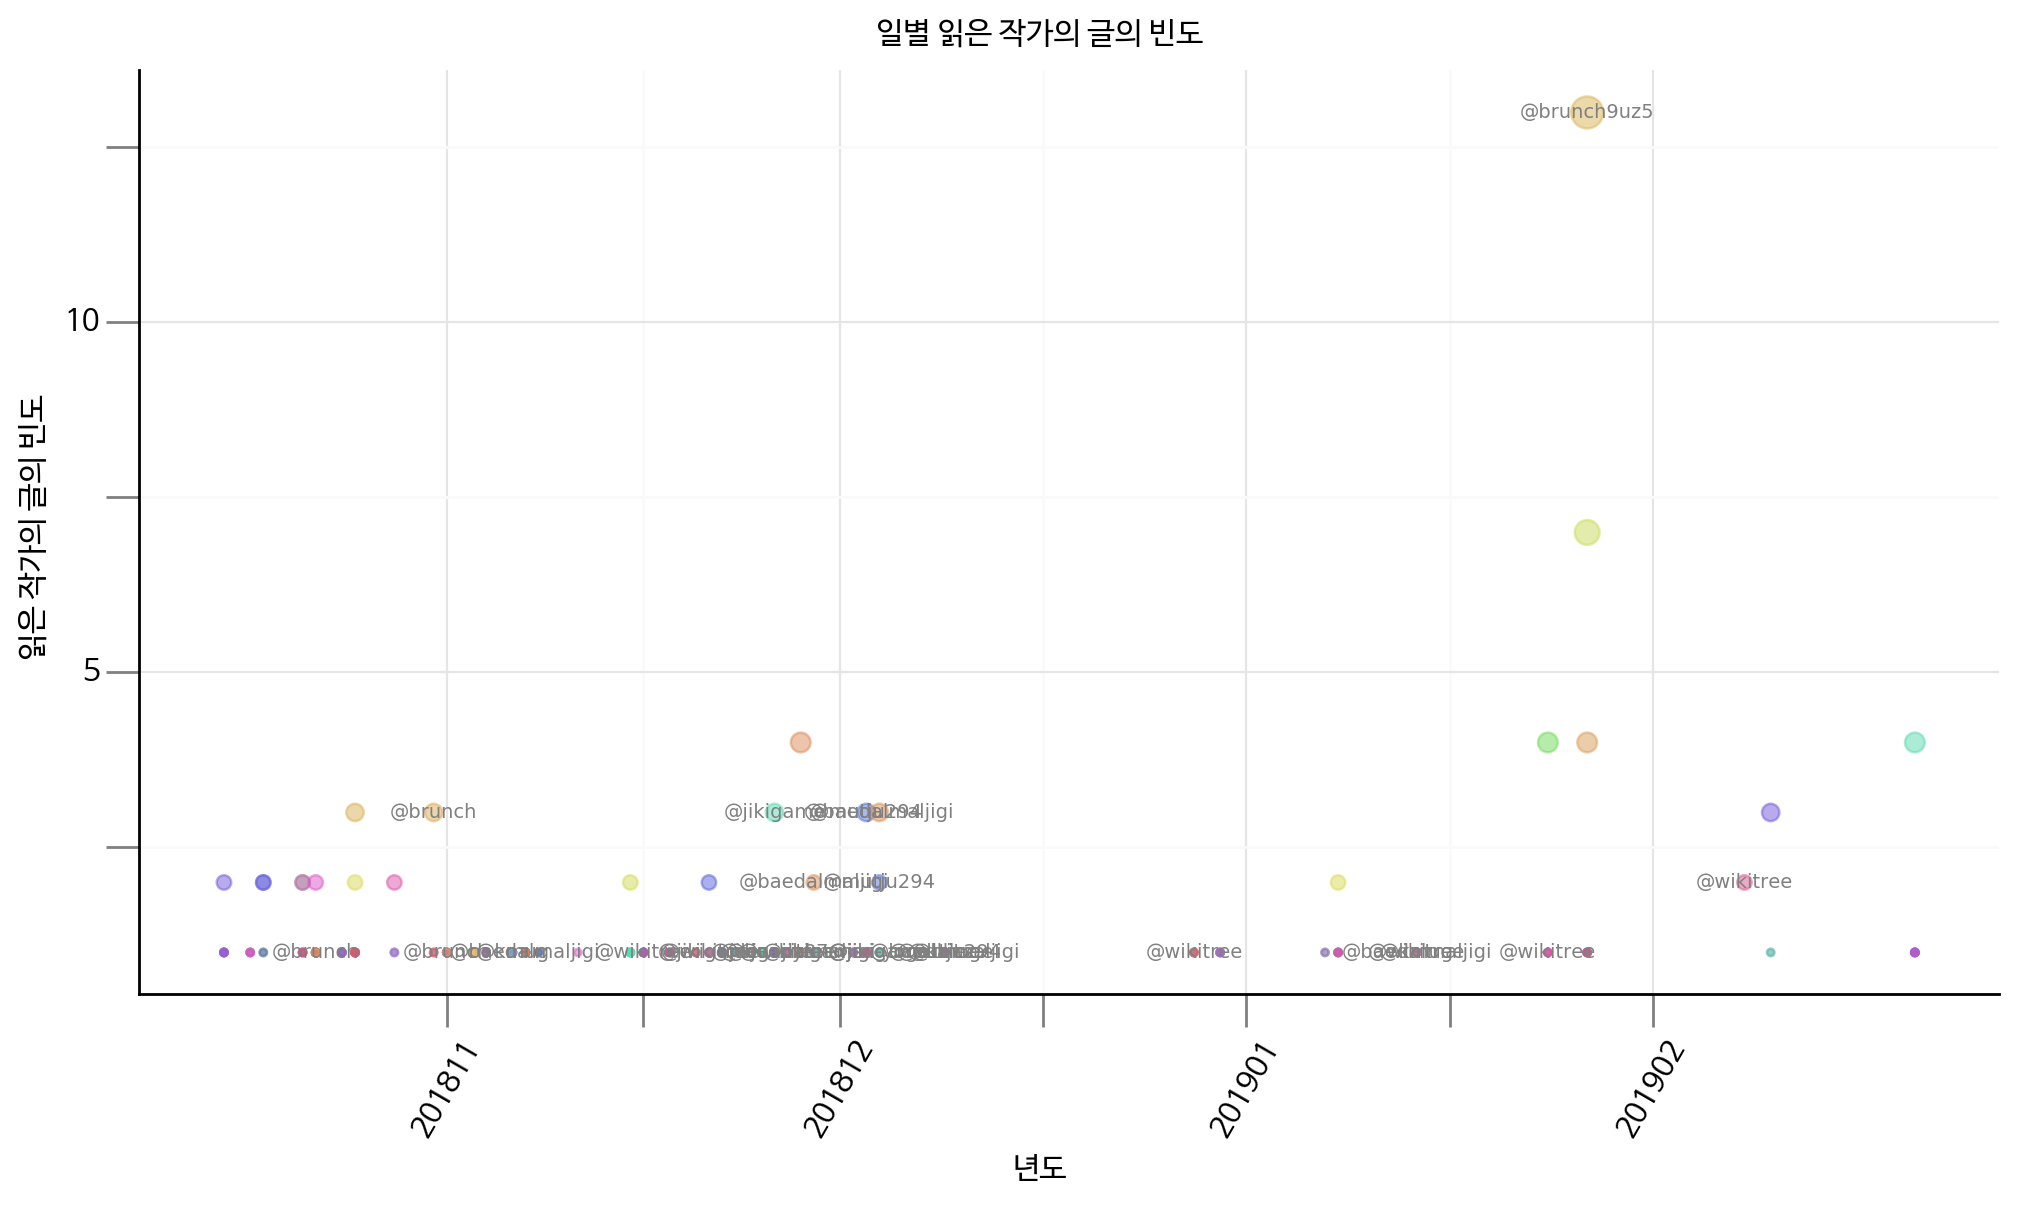

<ggplot: (-9223371843242334748)>

In [190]:
from mizani.breaks import date_breaks
from mizani.formatters import date_format

(ggplot(data=read_user)
    + geom_point(aes(x='reg_dt', y='count', color='author_id', size='count'), alpha = 0.5, show_legend=False)
    + geom_text(aes(x='reg_dt', y='count', label='author_id'), color='grey', 
               data = read_user[read_user['is_following'] == 1], size=7)
    + scale_x_datetime(breaks=date_breaks('1 month'), labels=date_format('%Y%m'))
    + theme_minimal()
    + ggtitle("일별 읽은 작가의 글의 빈도")
    + labs(x="년도", y="읽은 작가의 글의 빈도") 
    + theme(text = element_text(fontproperties=font),
         axis_text_x = element_text(angle=60, color='black'),
         axis_text_y = element_text(color='black'),
         axis_line=element_line(color="black"),
         axis_ticks=element_line(color = "grey"),
         figure_size=(12,6))
 )

위를 통해 판단할 수 있는 정보는 **추천시에 해당 정보들을 토대로 시간에 따라서 사용자의 선호가 바뀐 것은 아닌지, 구독한 작가만의 글을 읽는 게 신뢰할 만한지에 대해 정확히 따져봐야 합니다.**

## 데이터 탐색 - metadata

In [180]:
metadata.head()

,magazine_id,user_id,title,keyword_list,display_url,sub_title,reg_ts,article_id,id
0,8982,@bookdb,"사진으로 옮기기에도 아까운, 리치필드 국립공원","[여행, 호주, 국립공원]",https://brunch.co.kr/@bookdb/782,세상 어디에도 없는 호주 Top 10,1474944427000,782,@bookdb_782
1,12081,@kohwang56,[시] 서러운 봄,"[목련꽃, 아지랑이, 동행]",https://brunch.co.kr/@kohwang56/81,,1463092749000,81,@kohwang56_81
2,0,@hannahajink,무엇을 위해,[],https://brunch.co.kr/@hannahajink/4,무엇 때문에,1447997287000,4,@hannahajink_4
3,16315,@bryceandjuli,싫다,"[감정, 마음, 위로]",https://brunch.co.kr/@bryceandjuli/88,,1491055161000,88,@bryceandjuli_88
4,29363,@mijeongpark,Dubliner#7,"[유럽여행, 더블린, 아일랜드]",https://brunch.co.kr/@mijeongpark/34,#7. 내 친구의 집은 어디인가,1523292942000,34,@mijeongpark_34


In [181]:
from datetime import datetime 
metadata['reg_datetime'] = metadata['reg_ts'].apply(lambda x : datetime.fromtimestamp(x/1000.0))
metadata.loc[metadata['reg_datetime'] == metadata['reg_datetime'].min(), 'reg_datetime'] = datetime(2090, 12, 31)
metadata['reg_dt'] = metadata['reg_datetime'].dt.date
metadata['type'] = metadata['magazine_id'].apply(lambda x : '개인' if x == 0.0 else '매거진')
metadata['reg_dt'] = pd.to_datetime(metadata['reg_dt'])

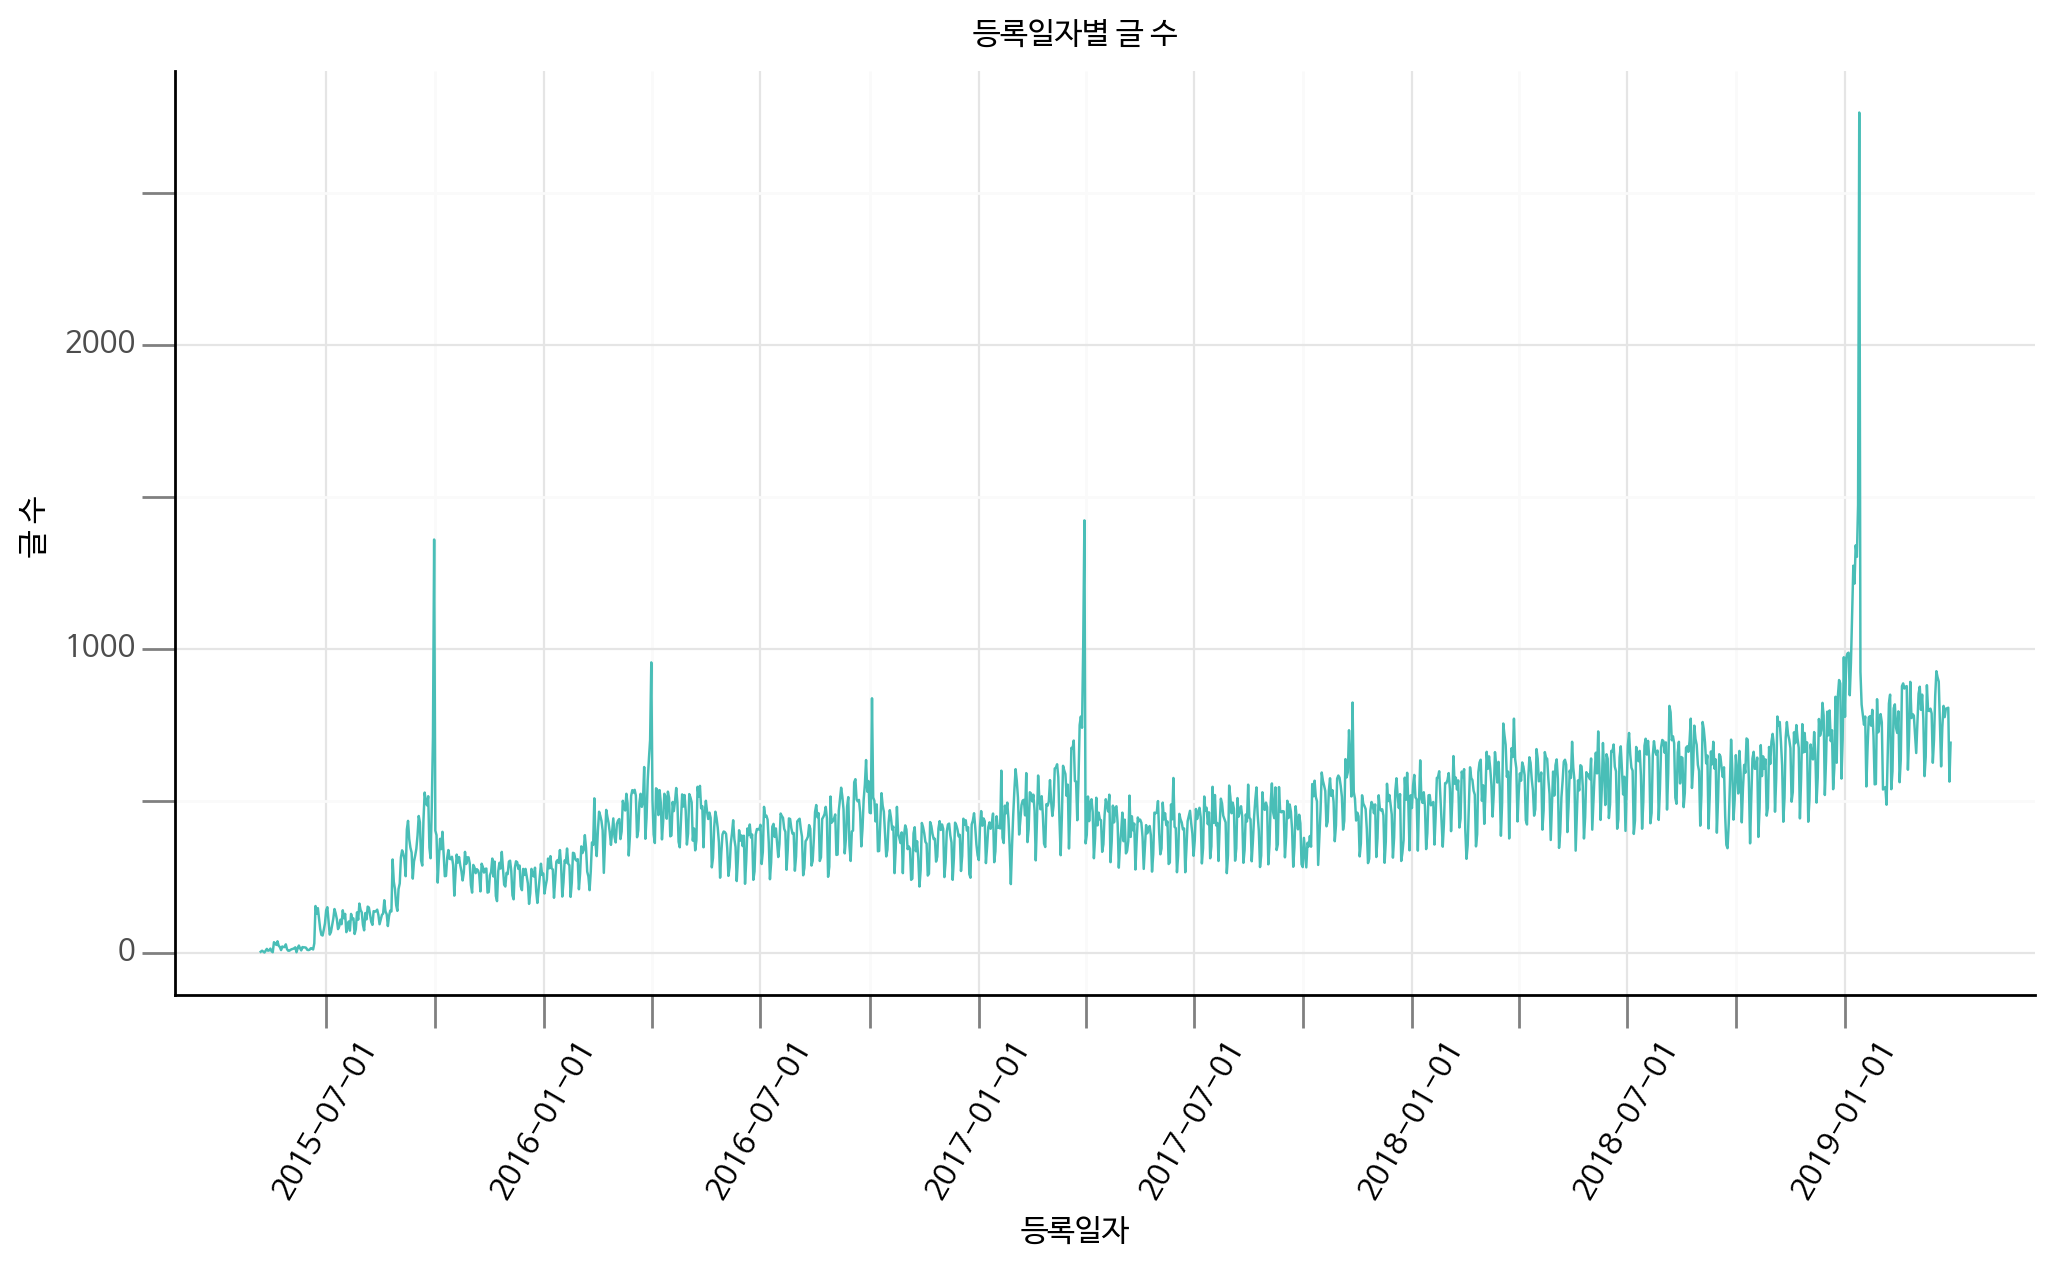

<ggplot: (193655722111)>

In [188]:
read_cnt_by_reg_dt = pd.DataFrame(metadata.groupby('reg_dt')['article_id'].count()).reset_index()
read_cnt_by_reg_dt = read_cnt_by_reg_dt.iloc[:-1]

(ggplot(data=read_cnt_by_reg_dt)
    + geom_line(aes(x='reg_dt', y='article_id'), colour = '#49beb7')
    + theme_minimal()
    + ggtitle("등록일자별 글 수")
    + labs(x="등록일자", y="글 수") 
    + theme(text = element_text(fontproperties=font),
         axis_text_x = element_text(angle=60, color='black'),
         axis_line=element_line(color="black"),
         axis_ticks=element_line(color = "grey"),
         figure_size=(12,6))
 )